In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 30)

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from collections import Counter
import glob

import warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
path = r'../input/used-car-dataset-ford-and-mercedes'
all_files = glob.glob(path + "/*.csv")
del all_files[1]
del all_files[-2]

car_types = []
frames = []

for path in all_files:
    car_types.append(path.split('/')[-1][:-4])

for filename, car_type in zip(all_files, car_types):
    df = pd.read_csv(filename, index_col=None, header=0)
    df['type'] = car_type
    frames.append(df)

df = pd.concat(frames, axis=0, ignore_index=True)

In [3]:
# the tax columns are separated due to different column names
df['tax'] = df.apply(
    lambda row: row['tax(£)'] if np.isnan(row['tax']) else row['tax'],
    axis=1
)
df.drop('tax(£)', axis=1, inplace=True)

# Exploring

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   engineSize    108540 non-null  float64
 7   type          108540 non-null  object 
 8   tax           99187 non-null   float64
 9   mpg           99187 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 8.3+ MB


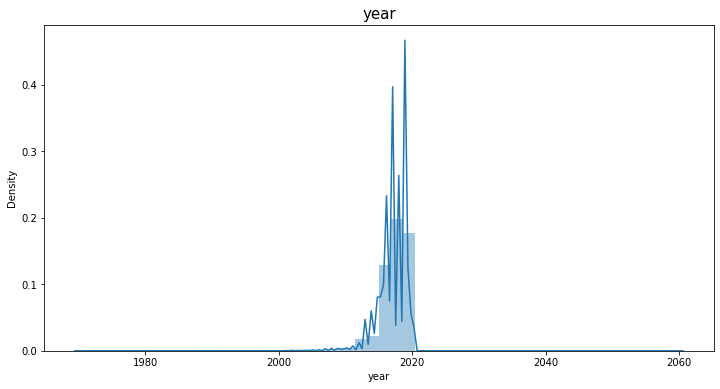

In [5]:
plt.figure(figsize=(12, 6))
sns.distplot(df.year)
plt.title('year', fontsize=15)
plt.show()

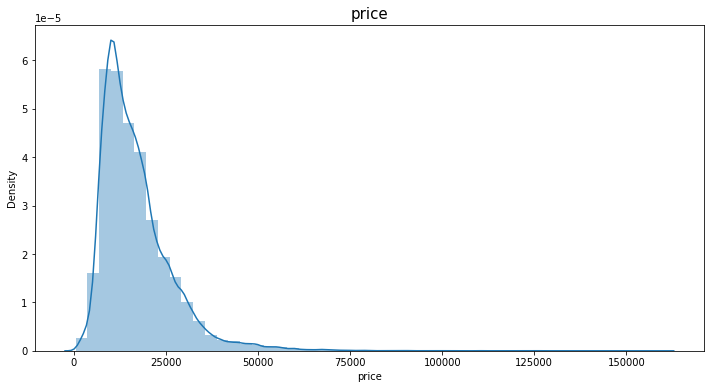

In [6]:
plt.figure(figsize=(12, 6))
sns.distplot(df.price)
plt.title('price', fontsize=15)
plt.show()

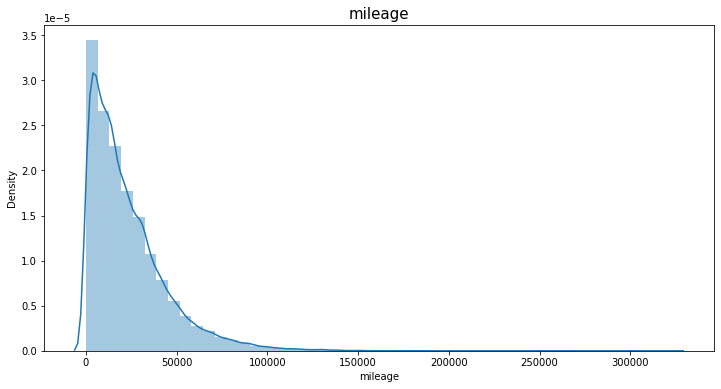

In [7]:
plt.figure(figsize=(12, 6))
sns.distplot(df.mileage)
plt.title('mileage', fontsize=15)
plt.show()

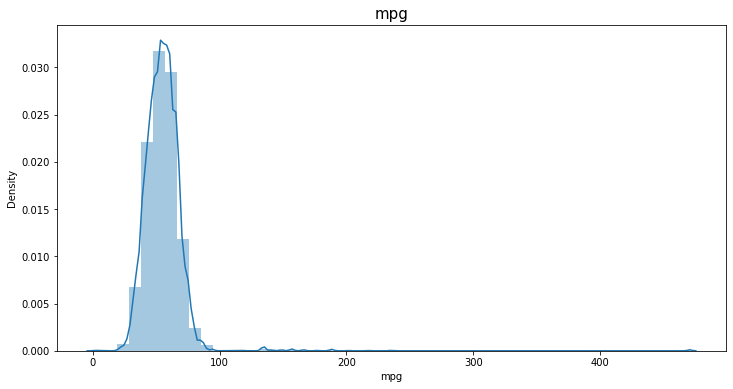

In [8]:
plt.figure(figsize=(12, 6))
sns.distplot(df.mpg)
plt.title('mpg', fontsize=15)
plt.show()

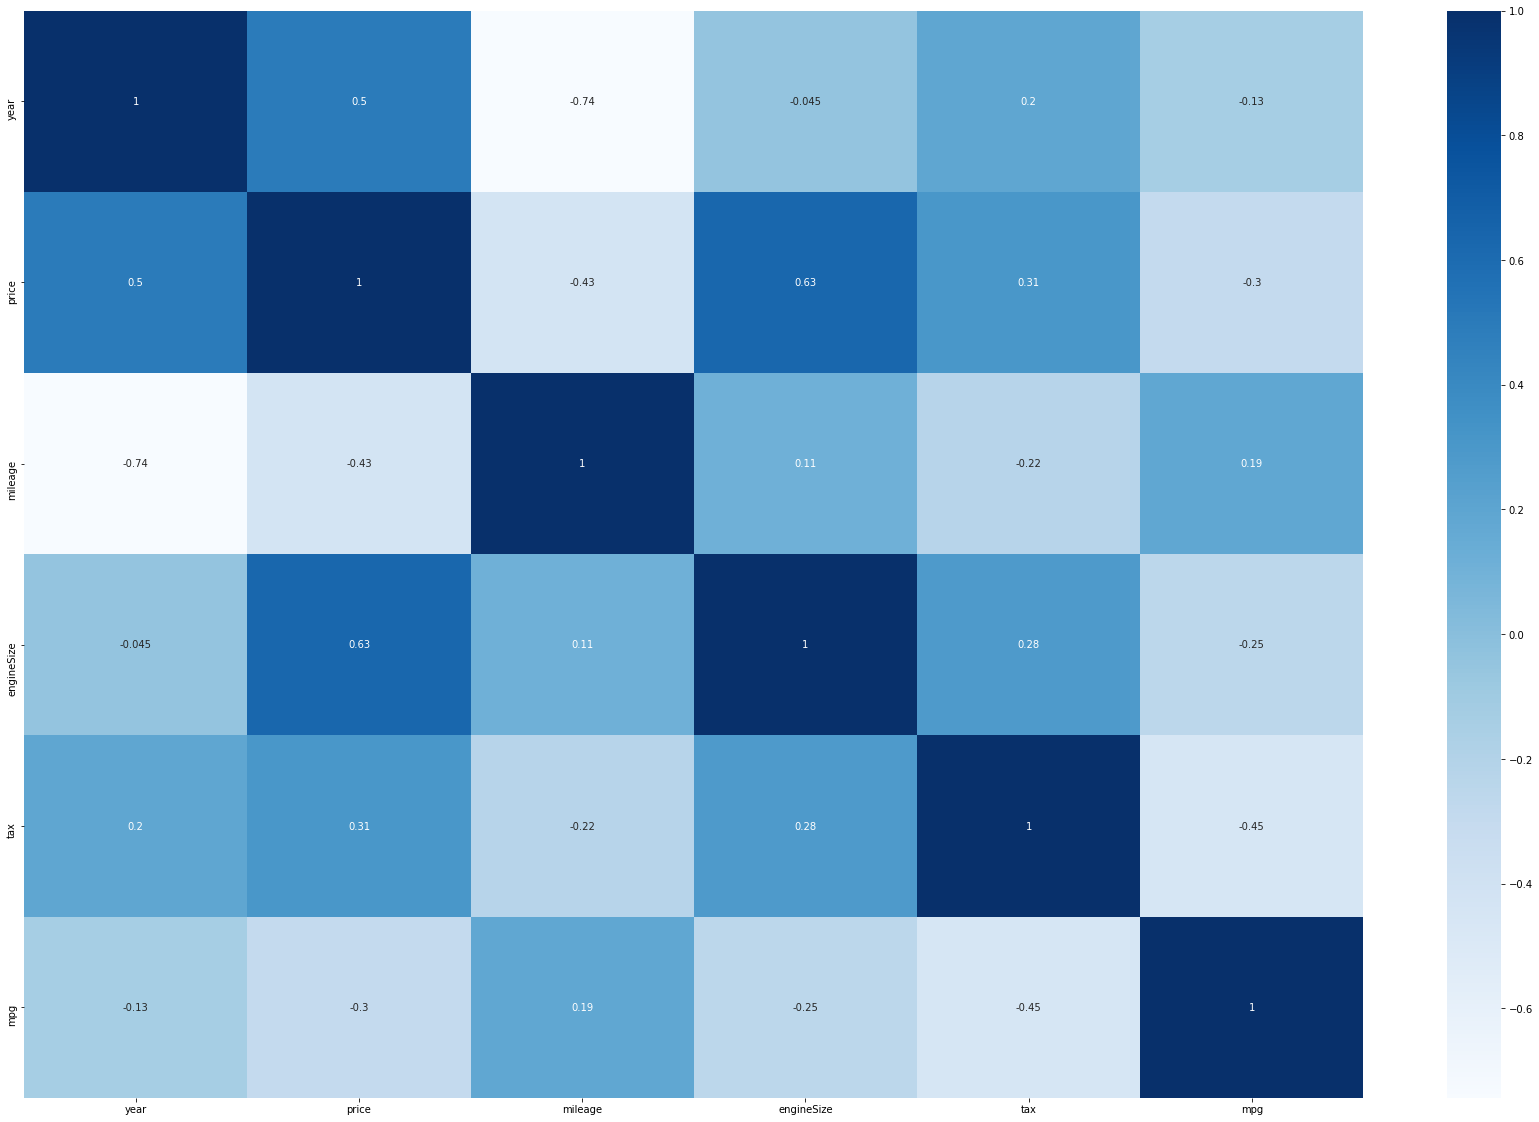

In [9]:
# Feature correlation
plt.figure(figsize=(30,20))
corr_mx = df.corr()
sns.heatmap(corr_mx, annot=True, cmap=plt.cm.Blues)
plt.show()

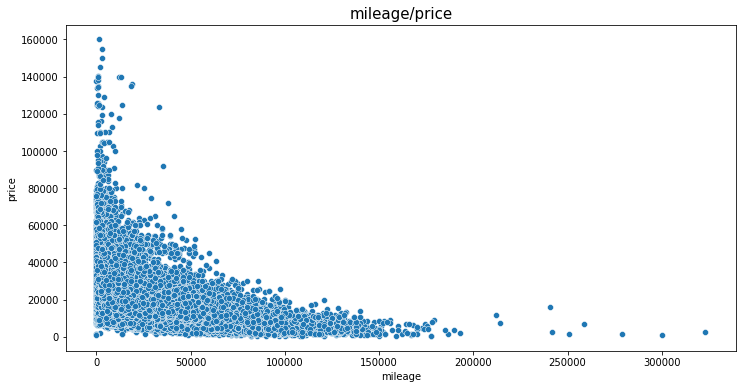

In [10]:
plt.figure(figsize=(12, 6))
sns.scatterplot(df.mileage, df.price)
plt.title('mileage/price', fontsize=15)
plt.show()

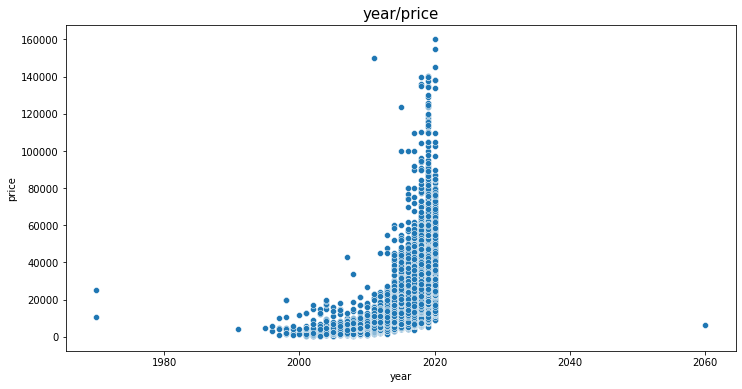

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(df.year, df.price)
plt.title('year/price', fontsize=15)
plt.show()

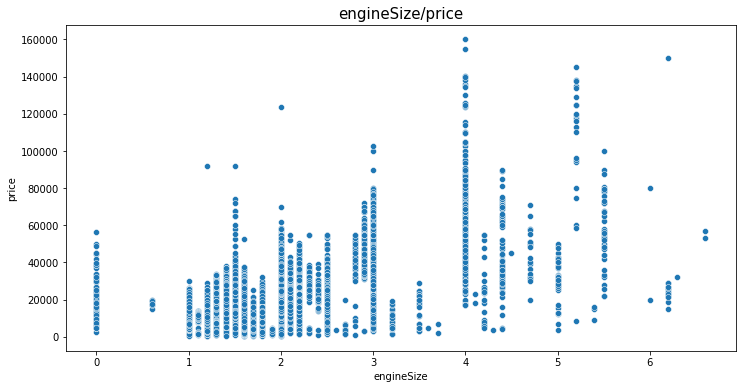

In [12]:
plt.figure(figsize=(12, 6))
sns.scatterplot(df.engineSize, df.price)
plt.title('engineSize/price', fontsize=15)
plt.show()

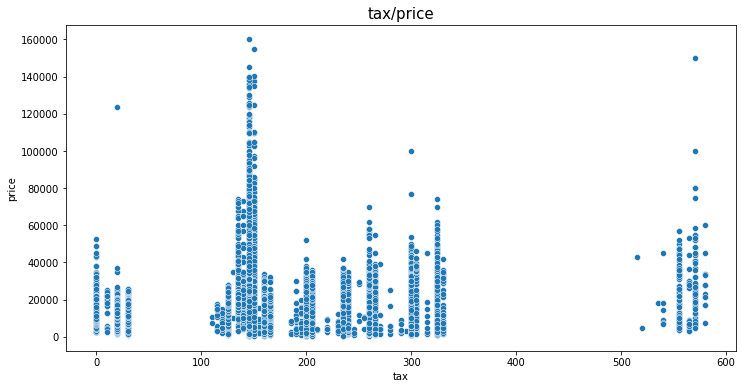

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(df.tax, df.price)
plt.title('tax/price', fontsize=15)
plt.show()

# Data cleaning and preprocessing

In [4]:
df = df[df['engineSize'] > 0.0]
df['tax'].fillna(value=0, inplace=True)
df['mpg'].fillna(value=df.mpg.median(), inplace=True)
df = df[df['transmission'] != 'Other']
df = df[df['fuelType'] != 'Other']

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107993 entries, 0 to 108539
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         107993 non-null  object 
 1   year          107993 non-null  int64  
 2   price         107993 non-null  int64  
 3   transmission  107993 non-null  object 
 4   mileage       107993 non-null  int64  
 5   fuelType      107993 non-null  object 
 6   engineSize    107993 non-null  float64
 7   type          107993 non-null  object 
 8   tax           107993 non-null  float64
 9   mpg           107993 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 9.1+ MB


In [5]:
def preprocess(df):
    cat_vars = pd.get_dummies(df[['transmission', 'fuelType', 'type']])
    df = df.drop(columns=['transmission', 'fuelType', 'type', 'model'], axis=1)
    
    return pd.concat([df, cat_vars], axis=1)

data_Xy = preprocess(df)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    data_Xy.drop('price', axis=1), data_Xy['price'],
    test_size=0.25,
    shuffle=True,
    random_state=42
)

y_train = np.log(y_train) # taking logarithm of target variable since there are big differences in price
y_test = np.log(y_test)

In [8]:
from sklearn.preprocessing import RobustScaler

# scalling continuous variables
scaler = RobustScaler().fit(X_train.iloc[:,[0, 1, 2, 3, 4]])

X_train.iloc[:,[0, 1, 2, 3, 4]] = scaler.transform(X_train.iloc[:,[0, 1, 2, 3, 4]])
X_test.iloc[:,[0, 1, 2, 3, 4]] = scaler.transform(X_test.iloc[:,[0, 1, 2, 3, 4]])

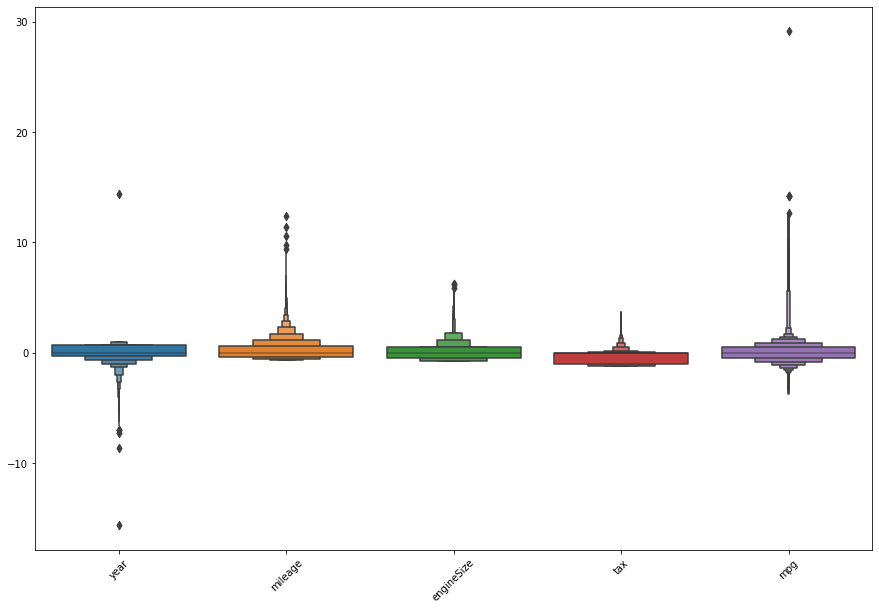

In [9]:
plt.figure(figsize=(15,10))
sns.boxenplot(data = X_train.select_dtypes('float64'))
plt.xticks(rotation=45)
plt.show()

In [11]:
Xy_train = pd.concat([X_train, y_train], axis=1)

Xy_train = Xy_train[abs(Xy_train['year']) < 8]
Xy_train = Xy_train[Xy_train['mileage'] < 7]
Xy_train = Xy_train[Xy_train['tax'] < 3]
Xy_train = Xy_train[Xy_train['mpg'] < 15]

X_train = Xy_train.drop('price', axis=1)
y_train = Xy_train['price']

# Model building

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [14]:
def train_and_eval(model):
    result = []
    scorer = make_scorer(r2_score, greater_is_better=True)
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    result.append(model.__class__.__name__)
    result.append(np.mean(cv_score))
    result.append(model.score(X_train, y_train))
    result.append(model.score(X_test, y_test))
    result.append(mean_squared_error(np.exp(y_train), np.exp(y_pred_train)))
    result.append(mean_squared_error(np.exp(y_test), np.exp(y_pred_test)))
    result.append(mean_absolute_error(np.exp(y_train), np.exp(y_pred_train)))
    result.append(mean_absolute_error(np.exp(y_test), np.exp(y_pred_test)))
    
    return result

estimators = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor()
]

all_results = pd.DataFrame(
    columns=[
        'estimator', 'r2_coef_mean (cv)',
        'r2_coef_train', 'r2_coef_test',
        'MSE_train', 'MSE_test', 'MAE_train', 'MAE_test'
    ]
)

for model in estimators:
    result = train_and_eval(model)
    dict_result = {}
    for i in range(len(all_results.columns)):
        dict_result[all_results.columns[i]] = result[i]
    all_results = all_results.append(dict_result, ignore_index = True)

all_results

,estimator,r2_coef_mean (cv),r2_coef_train,r2_coef_test,MSE_train,MSE_test,MAE_train,MAE_test
0,LinearRegression,0.888511,0.888638,0.887538,1.385994e+07,1.337474e+07,2296.872446,2292.754256
1,DecisionTreeRegressor,0.922562,0.999483,0.923679,1.111564e+05,7.775811e+06,34.816802,1624.490714
2,RandomForestRegressor,0.952812,0.993248,0.952843,8.588949e+05,5.308020e+06,509.761285,1331.414563
3,XGBRegressor,0.951701,0.960424,0.951339,4.539172e+06,5.702422e+06,1355.606122,1439.686129


**As we can see decision trees and random forest tend to overfit the training data a little. Next step would be to tune the algorithms and search for best parameters. For now XGB and RF are the most promising algrithms.**